# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Source catalogue

## Configuration

### Load libraries and setup

In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import pickle
import os
from glob import glob
from shutil import copyfile

In [2]:
from mltier1 import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimatorU, MultiMLEstimatorU,
                     parallel_process, get_sigma_all, get_q_m, get_threshold, q0_min_level, q0_min_numbers,
                     describe)

In [3]:
%load_ext autoreload

In [4]:
%autoreload

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### General configuration

In [6]:
save_intermediate = True
plot_intermediate = True

In [8]:
idp = "idata/main_v0.8"

In [9]:
if not os.path.isdir(idp):
    os.makedirs(idp)

### Area limits

In [10]:
ra_down0 = 170.0
ra_up0 = 190.0
dec_down0 = 45.5
dec_up0 = 56.5

In [11]:
# Busy week Edinburgh 2017
ra_down = 172.09
ra_up = 187.5833
dec_down = 46.106
dec_up = 56.1611

In [12]:
# Busy week Hatfield 2017
ra_down = 170.
ra_up = 190.
dec_down = 46.8
dec_up = 55.9

In [13]:
field = Field(170.0, 190.0, 46.8, 55.9)

In [14]:
field_full = Field(160.0, 232.0, 42.0, 62.0)

## Load data

In [15]:
combined_all = Table.read("pw.fits")

We will start to use the updated catalogues that include the output of the LOFAR Galaxy Zoo work.

In [16]:
#lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.9.srl.fits")
lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_merge_ID_optical_v0.8.fits")

In [17]:
np.array(combined_all.colnames)

array(['AllWISE', 'objID', 'ra', 'dec', 'raErr', 'decErr', 'W1mag',
       'W1magErr', 'i', 'iErr'],
      dtype='<U8')

In [18]:
np.array(lofar_all.colnames)

array(['Source_Name', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Peak_flux',
       'E_Peak_flux', 'Total_flux', 'E_Total_flux', 'Maj', 'E_Maj', 'Min',
       'E_Min', 'DC_Maj', 'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'PA', 'E_PA',
       'DC_PA', 'E_DC_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID',
       'Masked_Fraction', 'ID_flag', 'ID_name', 'ID_ra', 'ID_dec', 'ML_LR',
       'LGZ_Size', 'LGZ_Width', 'LGZ_PA', 'LGZ_Assoc', 'LGZ_Assoc_Qual',
       'LGZ_ID_Qual', 'AllWISE', 'objID', 'gFApFlux', 'gFApFluxErr',
       'gFApMag', 'gFApMagErr', 'rFApFlux', 'rFApFluxErr', 'rFApMag',
       'rFApMagErr', 'iFApFlux', 'iFApFluxErr', 'iFApMag', 'iFApMagErr',
       'zFApFlux', 'zFApFluxErr', 'zFApMag', 'zFApMagErr', 'yFApFlux',
       'yFApFluxErr', 'yFApMag', 'yFApMagErr', 'w1Flux', 'w1FluxErr',
       'w1Mag', 'w1MagErr', 'w2Flux', 'w2FluxErr', 'w2Mag', 'w2MagErr',
       'w3Flux', 'w3FluxErr', 'w3Mag', 'w3MagErr', 'w4Flux', 'w4FluxErr',
       'w4Mag', 'w4MagErr', 'XrayClass', '2RXS_ID', 'XMMSL2_ID', 'IRClass',
 

We show here the codes used and the number of sources with each code

In [19]:
codes, counts = np.unique(lofar_all['ID_flag'], return_counts=True)

In [20]:
print(list(zip(codes.filled(), counts)))

[(1, 300135), (2, 974), (4, 3410), (311, 10023), (312, 1675), (600, 645), (601, 69), (602, 1592), (603, 204), (610, 42)]


The columns of the original catalogue were the following:
```array(['Source_Name', 'RA', 'E_RA', 'E_RA_tot', 'DEC', 'E_DEC',
       'E_DEC_tot', 'Peak_flux', 'E_Peak_flux', 'E_Peak_flux_tot',
       'Total_flux', 'E_Total_flux', 'E_Total_flux_tot', 'Maj', 'E_Maj',
       'Min', 'E_Min', 'PA', 'E_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID',
       'Isl_id'],
      dtype='<U16')```

In [21]:
describe(lofar_all['Maj'])

8.148 +/- 2.671; median: 7.387; limits: [0.715, 84.092]; N=318769 (12984 NaN; 0 masked)


/disk2/jsm/prog/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:4125: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


### Filter catalogues

We will take the sources in the main region but also discard sources with a Major axis size bigger than 30 arsecs. We will also discard all the sources that are not classified with the code 1 in "ID_flag". Henceforth, we only take sources marked as "ML" only.

In [22]:
lofar_aux = lofar_all[~np.isnan(lofar_all['Maj'])]

In [23]:
lofar = field.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < 30.) &
                                         (lofar_aux['ID_flag'] == 1)], 
                               colnames=("RA", "DEC"))

In [24]:
lofar_full = field_full.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < 30.) &
                                                   (lofar_aux['ID_flag'] == 1)], 
                                         colnames=("RA", "DEC"))

In [25]:
combined = field.filter_catalogue(combined_all, 
                               colnames=("ra", "dec"))

### Additional data

In [26]:
combined["colour"] = combined["i"] - combined["W1mag"]

In [27]:
combined_aux_index = np.arange(len(combined))

### Sky coordinates

In [28]:
coords_combined = SkyCoord(combined['ra'], 
                           combined['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [29]:
coords_lofar = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

### Class of sources in the combined catalogue

The sources are grouped depending on the available photometric data.

In [30]:
combined_matched = (~np.isnan(combined["i"]) & ~np.isnan(combined["W1mag"])) # Matched i-W1 sources

In [31]:
combined_panstarrs = (~np.isnan(combined["i"]) & np.isnan(combined["W1mag"])) # Sources with only i-band

In [32]:
combined_wise =(np.isnan(combined["i"]) & ~np.isnan(combined["W1mag"])) # Sources with only W1-band

In [33]:
combined_i = combined_matched | combined_panstarrs
combined_w1 = combined_matched | combined_wise
#combined_only_i = combined_panstarrs & ~combined_matched
#combined_only_w1 = combined_wise & ~combined_matched

In [34]:
print("Total    - ", len(combined))
print("i and W1 - ", np.sum(combined_matched))
print("Only i   - ", np.sum(combined_panstarrs))
print("With i   - ", np.sum(combined_i))
print("Only W1  - ", np.sum(combined_wise))
print("With W1  - ", np.sum(combined_w1))

Total    -  3557679
i and W1 -  1109412
Only i   -  1778426
With i   -  2887838
Only W1  -  669839
With W1  -  1779251


### Colour categories

The colour categories will be used after the first ML match

In [35]:
colour_limits = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0]

In [36]:
# Start with the W1-only, i-only and "less than lower colour" bins
colour_bin_def = [{"name":"only W1", "condition": combined_wise},
                  {"name":"only i", "condition": combined_panstarrs},
                  {"name":"-inf to {}".format(colour_limits[0]), 
                   "condition": (combined["colour"] < colour_limits[0])}]

# Get the colour bins
for i in range(len(colour_limits)-1):
    name = "{} to {}".format(colour_limits[i], colour_limits[i+1])
    condition = ((combined["colour"] >= colour_limits[i]) & 
                 (combined["colour"] < colour_limits[i+1]))
    colour_bin_def.append({"name":name, "condition":condition})

# Add the "more than higher colour" bin
colour_bin_def.append({"name":"{} to inf".format(colour_limits[-1]), 
                       "condition": (combined["colour"] >= colour_limits[-1])})

/disk2/jsm/prog/anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)
/disk2/jsm/prog/anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, oper)(other)


In [37]:
combined["category"] = np.nan
for i in range(len(colour_bin_def)):
    combined["category"][colour_bin_def[i]["condition"]] = i

In [38]:
np.sum(np.isnan(combined["category"]))

2

We get the number of sources of the combined catalogue in each colour category. It will be used at a later stage to compute the $Q_0$ values

In [39]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [40]:
numbers_combined_bins

array([ 669839, 1778426,  123221,   86953,  127155,   91489,  106076,
        112638,  109949,   98183,   81055,   61913,   44390,   46507,
         14347,    5536])

## Description

### Sky coverage

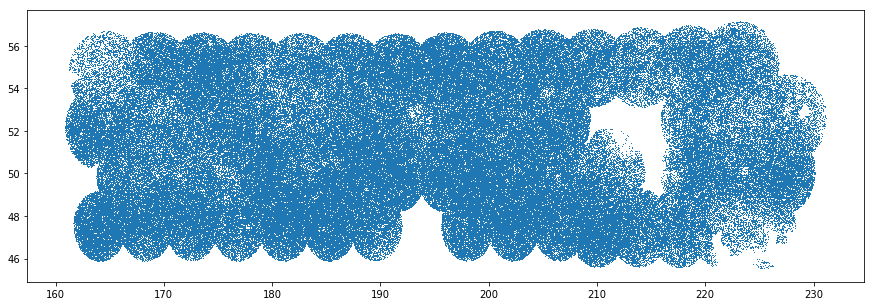

In [41]:
plt.rcParams["figure.figsize"] = (15,5)
plot(lofar_all["RA"],
     lofar_all["DEC"],
     ls="", marker=",");

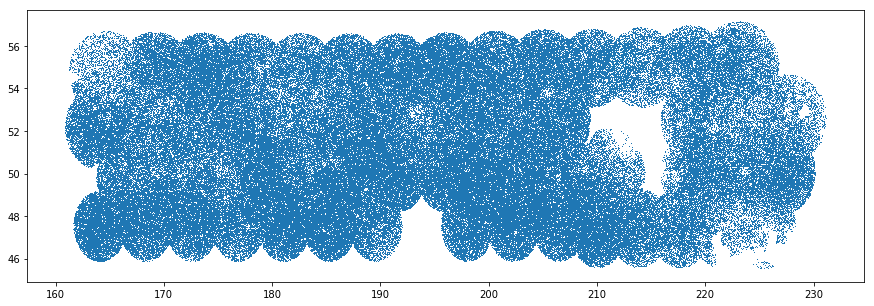

In [42]:
plt.rcParams["figure.figsize"] = (15,5)
plot(lofar_full["RA"],
     lofar_full["DEC"],
     ls="", marker=",");

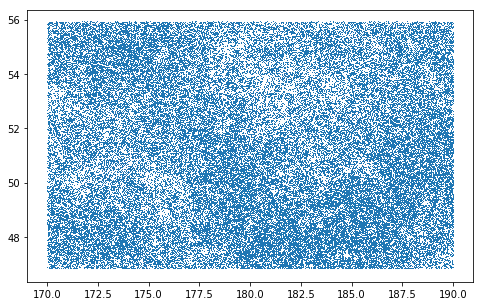

In [43]:
plt.rcParams["figure.figsize"] = (8,5)
plot(lofar["RA"],
     lofar["DEC"],
     ls="", marker=",");

In [44]:
len(lofar)

91332

### Summary of galaxy types in the combined catalogue

In [45]:
np.sum(combined_matched) # Matches

1109412

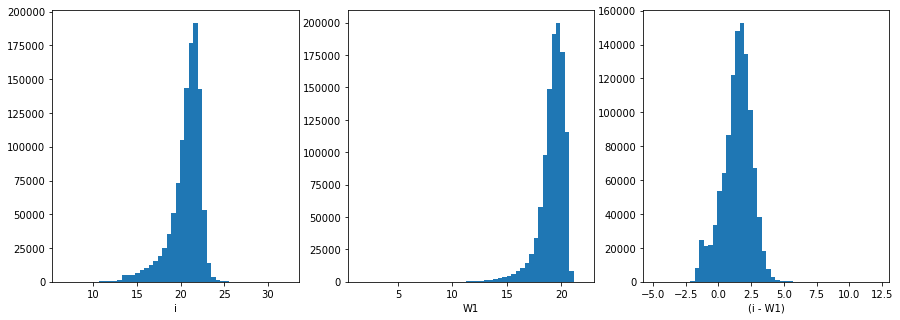

In [46]:
plt.rcParams["figure.figsize"] = (15,5)
subplot(1,3,1)
hist(combined["i"][combined_matched], bins=50)
xlabel("i")
subplot(1,3,2)
hist(combined["W1mag"][combined_matched], bins=50)
xlabel("W1")
subplot(1,3,3)
hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50)
xlabel("(i - W1)");

In [47]:
np.sum(combined_panstarrs) # Only PanSTARSS

1778426

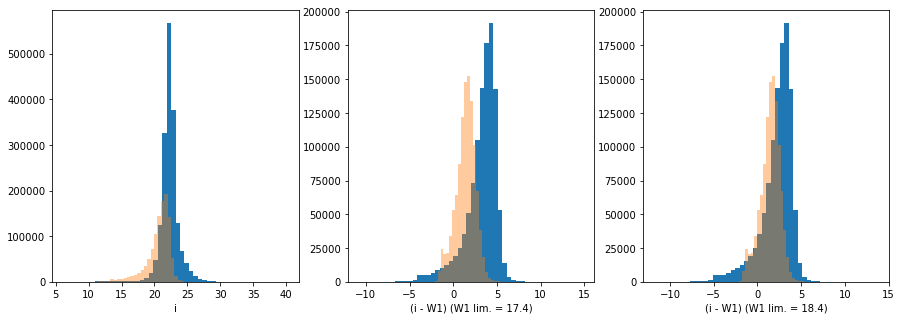

In [48]:
plt.rcParams["figure.figsize"] = (15,5)
subplot(1,3,1)
hist(combined["i"][combined_panstarrs], bins=50)
hist(combined["i"][combined_matched], bins=50, alpha=0.4)
xlabel("i")
subplot(1,3,2)
hist((combined["i"] - 17.4)[combined_matched], bins=50)
hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - W1) (W1 lim. = 17.4)")
subplot(1,3,3)
hist((combined["i"] - 18.4)[combined_matched], bins=50)
hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - W1) (W1 lim. = 18.4)");

In [49]:
np.sum(combined_wise) # Only WISE

669839

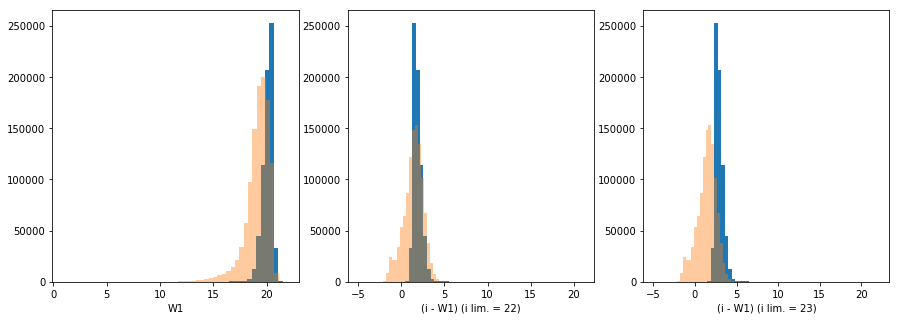

In [50]:
plt.rcParams["figure.figsize"] = (15,5)
subplot(1,3,1)
hist(combined["W1mag"][combined_wise], bins=50)
hist(combined["W1mag"][combined_matched], bins=50, alpha=0.4)
xlabel("W1")
subplot(1,3,2)
hist((22 - combined["W1mag"])[combined_wise], bins=50)
hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - W1) (i lim. = 22)")
subplot(1,3,3)
hist((23 - combined["W1mag"])[combined_wise], bins=50)
hist((combined["i"] - combined["W1mag"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - W1) (i lim. = 23)");

## Maximum Likelihood 1st

### i-band preparation

In [51]:
catalogue_i = combined[combined_i]

In [52]:
bin_list_i = np.linspace(12., 30., 361) # Bins of 0.05

In [53]:
center_i = get_center(bin_list_i)

In [54]:
n_m_i = get_n_m(catalogue_i["i"], bin_list_i, field.area)

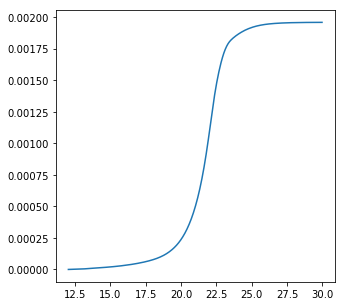

In [55]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_i, n_m_i);

In [56]:
q_m_i = estimate_q_m(catalogue_i["i"], bin_list_i, n_m_i, coords_lofar, coords_combined[combined_i], radius=5)

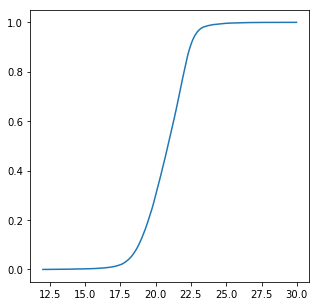

In [57]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_i, q_m_i);

### W1-band preparation

In [58]:
catalogue_w1 = combined[combined_w1]

In [59]:
bin_list_w1 = np.linspace(10., 23., 261) # Bins of 0.05

In [60]:
center_w1 = get_center(bin_list_w1)

In [61]:
n_m_w1 = get_n_m(catalogue_w1["W1mag"], bin_list_w1, field.area)

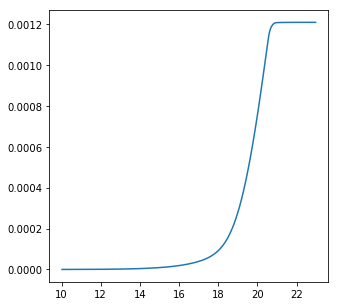

In [62]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_w1, n_m_w1);

In [63]:
q_m_w1 = estimate_q_m(catalogue_w1["W1mag"], 
                      bin_list_w1, 
                      n_m_w1, coords_lofar, 
                      coords_combined[combined_w1], 
                      radius=5)

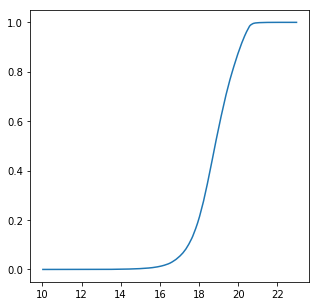

In [64]:
plot(center_w1, q_m_w1);

### $Q_0$ and likelihood estimators

In [65]:
# Old
Q0_i = 0.545
Q0_w1 = 0.77
# Better Q0
Q0_i = 0.503
Q0_w1 = 0.699
# Cleaned v0.7 Q0
Q0_i = 0.518
Q0_w1 = 0.713
# Cleaned v0.7 Q0 - 4 arcsecs
Q0_i = 0.513
Q0_w1 = 0.700

In [66]:
likelihood_ratio_i = SingleMLEstimatorU(Q0_i, n_m_i, q_m_i, center_i)

In [67]:
likelihood_ratio_w1 = SingleMLEstimatorU(Q0_w1, n_m_w1, q_m_w1, center_w1)

We will get the number of CPUs to use in parallel in the computations

In [68]:
import multiprocessing

In [69]:
n_cpus_total = multiprocessing.cpu_count()

In [70]:
n_cpus = max(1, n_cpus_total-1)

### i-band match

In [71]:
radius = 15

In [72]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_i], radius*u.arcsec)

In [73]:
idx_lofar_unique = np.unique(idx_lofar)

In [74]:
lofar["lr_i"] = np.nan                   # Likelihood ratio
lofar["lr_dist_i"] = np.nan              # Distance to the selected source
lofar["lr_index_i"] = np.nan             # Index of the PanSTARRS source in combined

In [75]:
total_sources = len(idx_lofar_unique)
combined_aux_index = np.arange(len(combined))

In [76]:
def ml(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    i_mag = catalogue_i["i"][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue_i["ra"][idx_0]
    c_dec = catalogue_i["dec"][idx_0]
    c_ra_err = catalogue_i["raErr"][idx_0]
    c_dec_err = catalogue_i["decErr"][idx_0]
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_i(i_mag, d2d_0.arcsec, sigma, sigma_maj, sigma_min)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_i][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [77]:
res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)

100%|██████████| 79.9K/79.9K [05:21<00:00, 248it/s]
100%|██████████| 79869/79869 [00:00<00:00, 296314.82it/s]


In [78]:
(lofar["lr_index_i"][idx_lofar_unique], 
 lofar["lr_dist_i"][idx_lofar_unique], 
 lofar["lr_i"][idx_lofar_unique]) = list(map(list, zip(*res)))

#### Threshold and selection for i-band

In [79]:
lofar["lr_i"][np.isnan(lofar["lr_i"])] = 0

In [80]:
threshold_i = np.percentile(lofar["lr_i"], 100*(1 - Q0_i))

In [81]:
threshold_i

7.9106729537643217

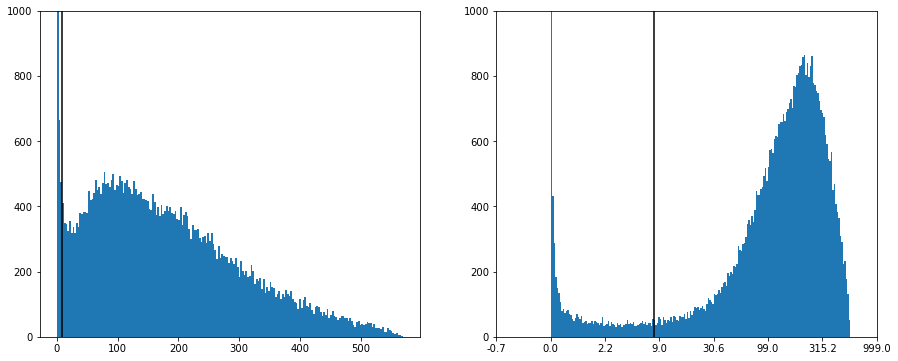

In [82]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_i"] != 0]["lr_i"], bins=200)
vlines([threshold_i], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_i"] != 0]["lr_i"]+1), bins=200)
vlines(np.log10(threshold_i+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [83]:
lofar["lr_index_sel_i"] = lofar["lr_index_i"]
lofar["lr_index_sel_i"][lofar["lr_i"] < threshold_i] = np.nan

### W1-band match

In [84]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_w1], radius*u.arcsec)

In [85]:
idx_lofar_unique = np.unique(idx_lofar)

In [86]:
lofar["lr_w1"] = np.nan                   # Likelihood ratio
lofar["lr_dist_w1"] = np.nan              # Distance to the selected source
lofar["lr_index_w1"] = np.nan             # Index of the PanSTARRS source in combined

In [87]:
def ml_w1(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    w1_mag = catalogue_w1["W1mag"][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue_w1["ra"][idx_0]
    c_dec = catalogue_w1["dec"][idx_0]
    c_ra_err = catalogue_w1["raErr"][idx_0]
    c_dec_err = catalogue_w1["decErr"][idx_0]
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_w1(w1_mag, d2d_0.arcsec, sigma, sigma_maj, sigma_min)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_w1][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [88]:
res = parallel_process(idx_lofar_unique, ml_w1, n_jobs=n_cpus)

100%|██████████| 83.7K/83.7K [08:30<00:00, 164it/s]
100%|██████████| 83719/83719 [00:00<00:00, 315223.25it/s]


In [89]:
(lofar["lr_index_w1"][idx_lofar_unique], 
 lofar["lr_dist_w1"][idx_lofar_unique], 
 lofar["lr_w1"][idx_lofar_unique]) = list(map(list, zip(*res)))

#### Threshold and selection for W1 band

In [90]:
lofar["lr_w1"][np.isnan(lofar["lr_w1"])] = 0

In [91]:
threshold_w1 = np.percentile(lofar["lr_w1"], 100*(1 - Q0_w1))

In [92]:
threshold_w1

1.2713413304137142

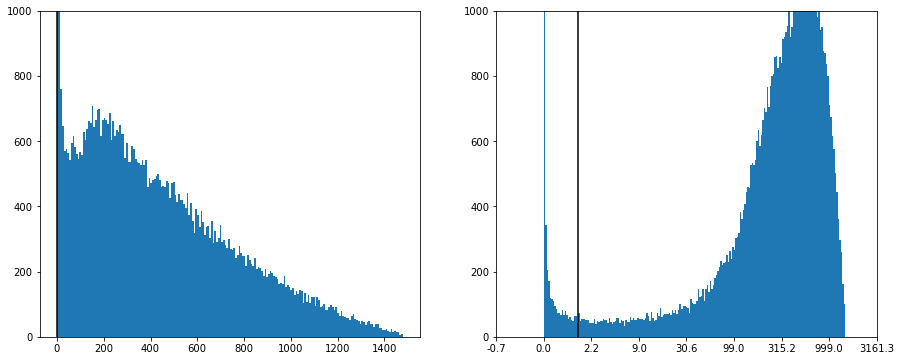

In [93]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_w1"] != 0]["lr_w1"], bins=200)
vlines([threshold_w1], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_w1"] != 0]["lr_w1"]+1), bins=200)
vlines(np.log10(threshold_w1+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [94]:
lofar["lr_index_sel_w1"] = lofar["lr_index_w1"]
lofar["lr_index_sel_w1"][lofar["lr_w1"] < threshold_w1] = np.nan

### Final selection of the match

We combine the ML matching done in i-band and W1-band. All the galaxies were the LR is above the selection ratio for the respective band are finally selected.

In [95]:
# lr_i_and_w1 = (lofar["lr_i"] != 0) & (lofar["lr_w1"] != 0)
# lr_only_i = (lofar["lr_i"] != 0) & (lofar["lr_w1"] == 0)
# lr_only_w1 = (lofar["lr_i"] == 0) & (lofar["lr_w1"] != 0)
# lr_no_match = (lofar["lr_i"] == 0) & (lofar["lr_w1"] == 0)
lr_i_and_w1 = ~np.isnan(lofar["lr_index_sel_i"]) & ~np.isnan(lofar["lr_index_sel_w1"])
lr_only_i = ~np.isnan(lofar["lr_index_sel_i"]) & np.isnan(lofar["lr_index_sel_w1"])
lr_only_w1 = np.isnan(lofar["lr_index_sel_i"]) & ~np.isnan(lofar["lr_index_sel_w1"])
lr_no_match = np.isnan(lofar["lr_index_sel_i"]) & np.isnan(lofar["lr_index_sel_w1"])

In [96]:
print(np.sum(lr_i_and_w1))
print(np.sum(lr_only_i))
print(np.sum(lr_only_w1))
print(np.sum(lr_no_match))

43395
3458
20537
23942


In [97]:
lofar["lr_index_1"] = np.nan
lofar["lr_dist_1"] = np.nan
lofar["lr_1"] = np.nan
lofar["lr_type_1"] = 0

In [98]:
# Only i matches
lofar["lr_1"][lr_only_i] = lofar["lr_i"][lr_only_i]
lofar["lr_index_1"][lr_only_i] = lofar["lr_index_i"][lr_only_i]
lofar["lr_dist_1"][lr_only_i] = lofar["lr_dist_i"][lr_only_i]
lofar["lr_type_1"][lr_only_i] = 1

# Only w1 matches
lofar["lr_1"][lr_only_w1] = lofar["lr_w1"][lr_only_w1]
lofar["lr_index_1"][lr_only_w1] = lofar["lr_index_w1"][lr_only_w1]
lofar["lr_dist_1"][lr_only_w1] = lofar["lr_dist_w1"][lr_only_w1]
lofar["lr_type_1"][lr_only_w1] = 2

# Both matches
lofar["lr_1"][lr_i_and_w1] = np.max([lofar["lr_i"][lr_i_and_w1], lofar["lr_w1"][lr_i_and_w1]], axis=0)
lofar["lr_type_1"][lr_i_and_w1] = np.argmax([lofar["lr_i"][lr_i_and_w1], lofar["lr_w1"][lr_i_and_w1]], axis=0) + 1

c1 = (lofar["lr_type_1"] == 1)
c2 = (lofar["lr_type_1"] == 2)
lofar["lr_index_1"][lr_i_and_w1 & c1] = lofar["lr_index_i"][lr_i_and_w1 & c1]
lofar["lr_index_1"][lr_i_and_w1 & c2] = lofar["lr_index_w1"][lr_i_and_w1 & c2]
lofar["lr_dist_1"][lr_i_and_w1 & c1] = lofar["lr_dist_i"][lr_i_and_w1 & c1]
lofar["lr_dist_1"][lr_i_and_w1 & c2] = lofar["lr_dist_w1"][lr_i_and_w1 & c2]

Summary of the number of sources matches of each type

In [99]:
print("match    sel-i: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match   sel-W1: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match     both: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1) + 
                          np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match   i-only: ", np.sum(lofar["lr_type_1"] == 1) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match  W1-only: ", np.sum(lofar["lr_type_1"] == 2) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match      all: ", np.sum(lofar["lr_type_1"] == 1) + 
                          np.sum(lofar["lr_type_1"] == 2))
print("         Total: ", len(lofar))

match    sel-i:  762
match   sel-W1:  42633
match     both:  43395
match   i-only:  3458
match  W1-only:  20537
match      all:  67390
         Total:  91332


The number of sources for which the match in i-band and W1-band are above the threshold but gives a different match to the combined catalogue.

In [100]:
print(np.sum(lofar["lr_index_i"][lr_i_and_w1] != lofar["lr_index_w1"][lr_i_and_w1]))

1468


#### Duplicated sources

This is the nymber of sources of the combined catalogue that are combined to multiple LOFAR sources. In the case of the catalogue of Gaussians the number can be very high.

In [101]:
values, counts = np.unique(lofar[lofar["lr_type_1"] != 0]["lr_index_1"], return_counts=True)

In [102]:
len(values[counts > 1])

4

In [103]:
n_dup, n_sour = np.unique(counts[counts > 1], return_counts=True)

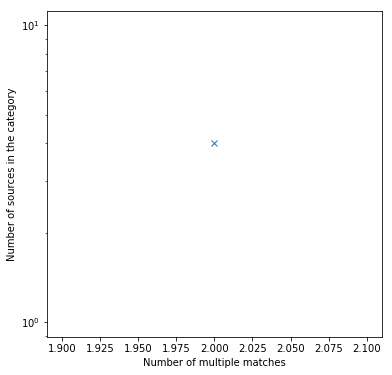

In [104]:
plt.rcParams["figure.figsize"] = (6,6)
semilogy(n_dup, n_sour, marker="x")
xlabel("Number of multiple matches")
ylabel("Number of sources in the category")

### Save intermediate data

In [105]:
if save_intermediate:
    pickle.dump([bin_list_i, center_i, Q0_i, n_m_i, q_m_i], 
                open("{}/lofar_params_1i.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_w1, center_w1, Q0_w1, n_m_w1, q_m_w1], 
                open("{}/lofar_params_1w1.pckl".format(idp), 'wb'))
    lofar.write("{}/lofar_m1.fits".format(idp), format="fits")

## Second iteration using colour

From now on we will take into account the effect of the colour. The sample was distributed in several categories according to the colour of the source and this is considered here.

### Rusable parameters for all the iterations

These parameters are derived from the underlying population and will not change.

First we compute the number of galaxies in each bin for the combined catalogue

In [106]:
bin_list = [bin_list_w1 if i == 0 else bin_list_i for i in range(len(colour_bin_def))]
centers = [center_w1 if i == 0 else center_i for i in range(len(colour_bin_def))]

In [107]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [108]:
numbers_combined_bins

array([ 669839, 1778426,  123221,   86953,  127155,   91489,  106076,
        112638,  109949,   98183,   81055,   61913,   44390,   46507,
         14347,    5536])

Get the colour category and magnitudes for the matched LOFAR sources

In [109]:
n_m = []

# W1 only sources
n_m.append(get_n_m(combined["W1mag"][combined["category"] == 0], bin_list_w1, field.area))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m.append(get_n_m(combined["i"][combined["category"] == i], bin_list_i, field.area))

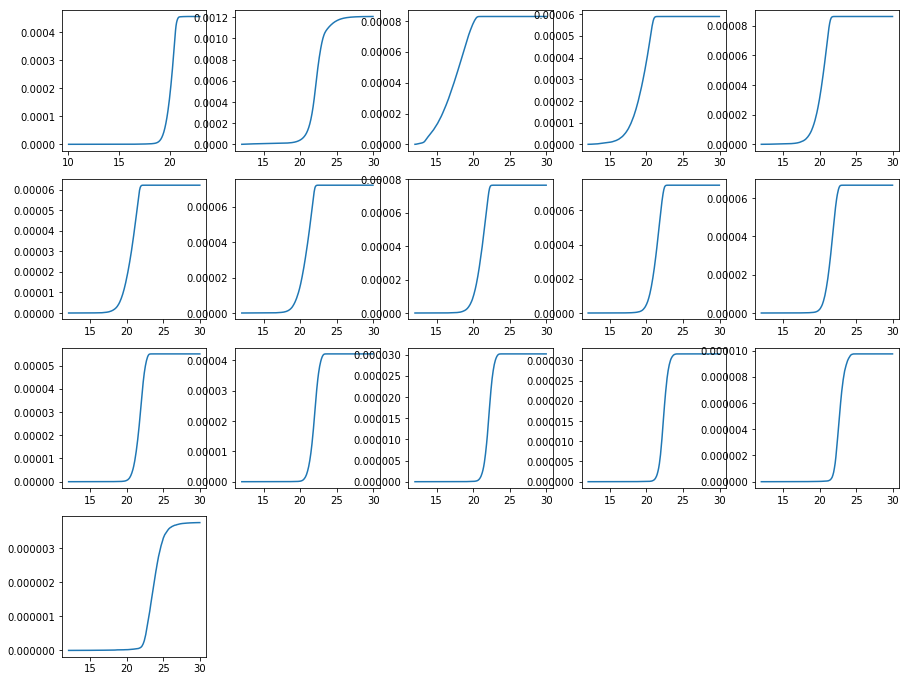

In [110]:
plt.rcParams["figure.figsize"] = (15,15)
for i, n_m_k in enumerate(n_m):
    subplot(5,5,i+1)
    plot(centers[i], n_m_k)

### Parameters of the matched sample

The parameters derived from the matched LOFAR galaxies: $q_0$, q(m) and the number of sources per category.

The columns "category", "W1mag" and "i" will contain the properties of the matched galaxies and will be updated in each iteration to save space.

In [111]:
lofar["category"] = np.nan
lofar["W1mag"] = np.nan
lofar["i"] = np.nan

In [112]:
c = ~np.isnan(lofar["lr_index_1"])
indices = lofar["lr_index_1"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["W1mag"][c] = combined[indices]["W1mag"]
lofar["i"][c] = combined[indices]["i"]

The next parameter represent the number of matched LOFAR sources in each colour category.

In [113]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])

In [114]:
numbers_lofar_combined_bins

array([19433,  4205,   202,   558,  2321,  3279,  4694,  5222,  5022,
        4540,  4329,  3813,  3272,  4320,  1654,   526])

The $Q_0$ for each category are obtained by dividing the number of sources in the category by the total number of sources in the sample.

In [115]:
Q_0_colour = numbers_lofar_combined_bins/len(lofar) ### Q_0

In [116]:
q0_total = np.sum(Q_0_colour)

In [117]:
q0_total

0.73785748697061271

The q(m) is not estimated with the method of Fleuren et al. but with the most updated distributions and numbers for the matches.

In [118]:
q_m = []
radius = 15. 

# W1 only sources
q_m.append(get_q_m(lofar["W1mag"][lofar["category"] == 0], 
                   bin_list_w1, 
                   numbers_lofar_combined_bins[0], 
                   n_m[0], 
                   field.area, 
                   radius=radius))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m.append(get_q_m(lofar["i"][lofar["category"] == i], 
                   bin_list_i, 
                   numbers_lofar_combined_bins[i], 
                   n_m[i], 
                   field.area, 
                   radius=radius))

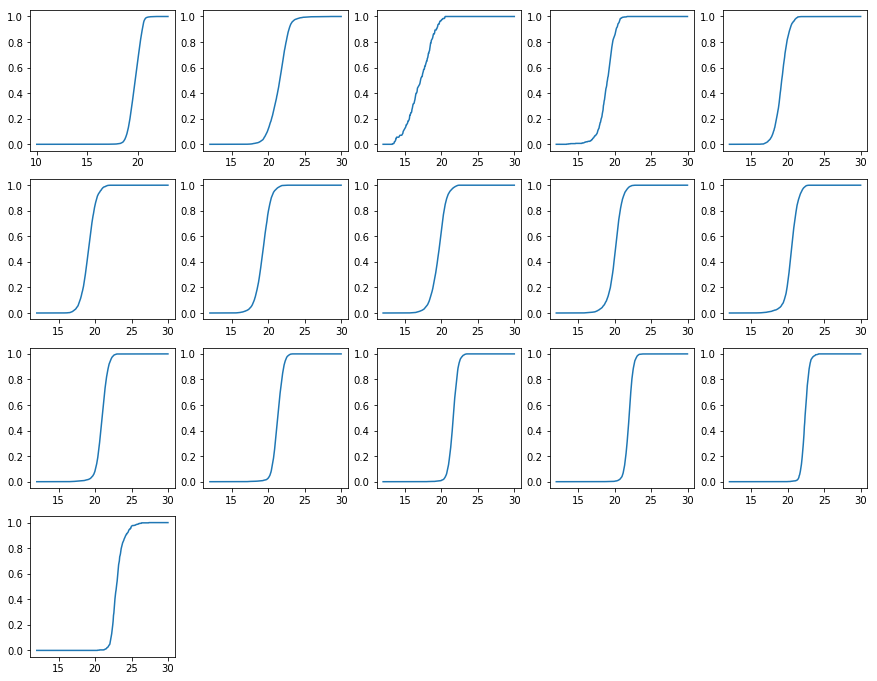

In [119]:
plt.rcParams["figure.figsize"] = (15,15)
for i, q_m_k in enumerate(q_m):
    subplot(5,5,i+1)
    plot(centers[i], q_m_k)

### Save intermediate parameters

In [120]:
if save_intermediate:
    pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                open("{}/lofar_params_2.pckl".format(idp), 'wb'))

### Prepare for ML

In [121]:
selection = ~np.isnan(combined["category"]) # Avoid the two dreaded sources with no actual data
catalogue = combined[selection]

In [122]:
radius = 15

In [123]:
def apply_ml(i, likelihood_ratio_function):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue["i"][idx_0]
    mag[category == 0] = catalogue["W1mag"][idx_0][category == 0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = catalogue["raErr"][idx_0]
    c_dec_err = catalogue["decErr"][idx_0]
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, sigma_maj, sigma_min, category)
    
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[selection][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

### Run the cross-match

This will not need to be repeated after

In [124]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[selection], radius*u.arcsec)

In [125]:
idx_lofar_unique = np.unique(idx_lofar)

### Run the ML matching

In [126]:
likelihood_ratio = MultiMLEstimatorU(Q_0_colour, n_m, q_m, centers)

In [127]:
def ml(i):
    return apply_ml(i, likelihood_ratio)

In [128]:
res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)

100%|██████████| 87.9K/87.9K [07:16<00:00, 201it/s]
100%|██████████| 87863/87863 [00:00<00:00, 313175.39it/s]


In [129]:
lofar["lr_index_2"] = np.nan
lofar["lr_dist_2"] = np.nan
lofar["lr_2"] = np.nan

In [130]:
(lofar["lr_index_2"][idx_lofar_unique], 
 lofar["lr_dist_2"][idx_lofar_unique], 
 lofar["lr_2"][idx_lofar_unique]) = list(map(list, zip(*res)))

Get the new threshold for the ML matching. FIX THIS

In [131]:
lofar["lr_2"][np.isnan(lofar["lr_2"])] = 0

In [132]:
threshold = np.percentile(lofar["lr_2"], 100*(1 - q0_total))
#manual_q0 = 0.65
#threshold = np.percentile(lofar["lr_2"], 100*(1 - manual_q0))

In [133]:
threshold

1.2962110512257572

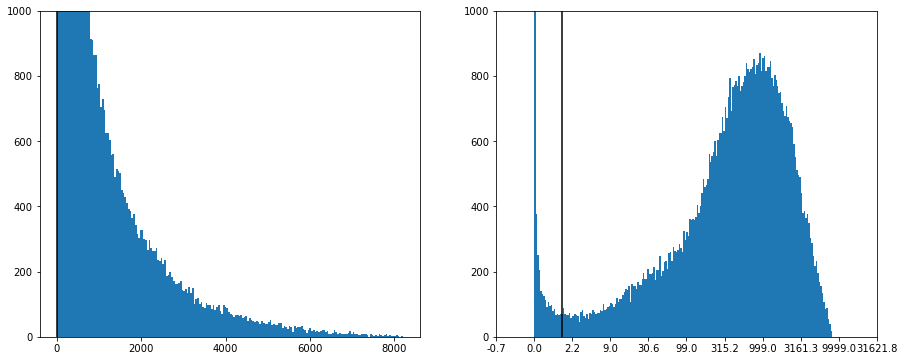

In [134]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_2"] != 0]["lr_2"], bins=200)
vlines([threshold], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_2"] != 0]["lr_2"]+1), bins=200)
vlines(np.log10(threshold+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [135]:
lofar["lr_index_sel_2"] = lofar["lr_index_2"]
lofar["lr_index_sel_2"][lofar["lr_2"] < threshold] = np.nan

In [136]:
n_changes = np.sum((lofar["lr_index_sel_2"] != lofar["lr_index_1"]) & 
                   ~np.isnan(lofar["lr_index_sel_2"]) &
                   ~np.isnan(lofar["lr_index_1"]))

In [137]:
n_changes

442

Enter the results

In [138]:
# Clear aux columns
lofar["category"] = np.nan
lofar["W1mag"] = np.nan
lofar["i"] = np.nan

c = ~np.isnan(lofar["lr_index_sel_2"])
indices = lofar["lr_index_sel_2"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["W1mag"][c] = combined[indices]["W1mag"]
lofar["i"][c] = combined[indices]["i"]

In [139]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])

In [140]:
numbers_lofar_combined_bins

array([19572,  3805,    83,   505,  2306,  3299,  4732,  5270,  5076,
        4582,  4380,  3859,  3313,  4401,  1673,   534])

### Save intermediate data

In [141]:
if save_intermediate:
    lofar.write("{}/lofar_m2.fits".format(idp), format="fits")

## Iterate until convergence

In [142]:
rerun_iter = True

In [143]:
if rerun_iter:
    lofar = Table.read("{}/lofar_m2.fits".format(idp))
    bin_list, centers, Q_0_colour, n_m, q_m = pickle.load(open("{}/lofar_params_2.pckl".format(idp), 'rb'))
    inter_data_list = glob("{}/lofar_m*.fits".format(idp))
    # Remove data
    for inter_data_file in inter_data_list:
        if inter_data_file[-7:-5] not in ["m1", "m2"]:
            #print(inter_data_file)
            os.remove(inter_data_file)
    # Remove images
    images_list = glob("{}/*.png".format(idp))
    for images in images_list:
        #print(images)
        os.remove(images)
    # Remove parameters
    inter_param_list = glob("{}/lofar_params_*.pckl".format(idp))
    for inter_param_file in inter_param_list:
        if inter_param_file[-7:-5] not in ["1i", "w1", "_2"]:
            #print(inter_param_file)
            os.remove(inter_param_file)

In [144]:
radius = 15. 

In [145]:
from matplotlib import pyplot as plt

Iteration 3
numbers_lofar_combined_bins
[19572  3805    83   505  2306  3299  4732  5270  5076  4582  4380  3859
  3313  4401  1673   534]
Q_0_colour
[ 0.2142951   0.04166119  0.001       0.00552928  0.02524854  0.03612097
  0.05181098  0.05770157  0.05557745  0.05016862  0.0479569   0.04225244
  0.03627425  0.04818683  0.01831779  0.0058468 ]
Q_0_total:  0.73794871458


100%|██████████| 87.9K/87.9K [07:09<00:00, 205it/s]
100%|██████████| 87863/87863 [00:00<00:00, 313543.63it/s]


Threshold:  1.21444454861
N changes:  23
T changes:  24008
******** continue **********
Iteration 4
numbers_lofar_combined_bins
[19604  3769    59   501  2307  3302  4733  5272  5082  4583  4384  3861
  3316  4409  1678   538]
Q_0_colour
[ 0.21464547  0.04126703  0.001       0.00548548  0.02525949  0.03615381
  0.05182192  0.05772347  0.05564315  0.05017956  0.0480007   0.04227434
  0.0363071   0.04827443  0.01837253  0.0058906 ]
Q_0_total:  0.738299084658


100%|██████████| 87.9K/87.9K [07:08<00:00, 205it/s]
100%|██████████| 87863/87863 [00:00<00:00, 296739.33it/s]


Threshold:  1.15556926477
N changes:  2
T changes:  23945
******** continue **********
Iteration 5
numbers_lofar_combined_bins
[19617  3778    53   503  2309  3303  4735  5272  5083  4586  4385  3862
  3316  4411  1679   538]
Q_0_colour
[ 0.21478781  0.04136557  0.001       0.00550738  0.02528139  0.03616476
  0.05184382  0.05772347  0.0556541   0.05021241  0.04801165  0.04228529
  0.0363071   0.04829633  0.01838348  0.0058906 ]
Q_0_total:  0.738715149126


100%|██████████| 87.9K/87.9K [07:11<00:00, 204it/s]
100%|██████████| 87863/87863 [00:00<00:00, 295811.81it/s]


Threshold:  1.08691386731
N changes:  1
T changes:  23912
******** continue **********
Iteration 6
numbers_lofar_combined_bins
[19637  3786    46   504  2312  3305  4736  5273  5085  4588  4386  3863
  3317  4412  1680   538]
Q_0_colour
[ 0.21500679  0.04145316  0.001       0.00551833  0.02531424  0.03618666
  0.05185477  0.05773442  0.055676    0.05023431  0.0480226   0.04229624
  0.03631805  0.04830727  0.01839443  0.0058906 ]
Q_0_total:  0.739207857049


100%|██████████| 87.9K/87.9K [07:17<00:00, 201it/s]
100%|██████████| 87863/87863 [00:00<00:00, 310373.49it/s]


Threshold:  1.00653249095
N changes:  0
T changes:  23873


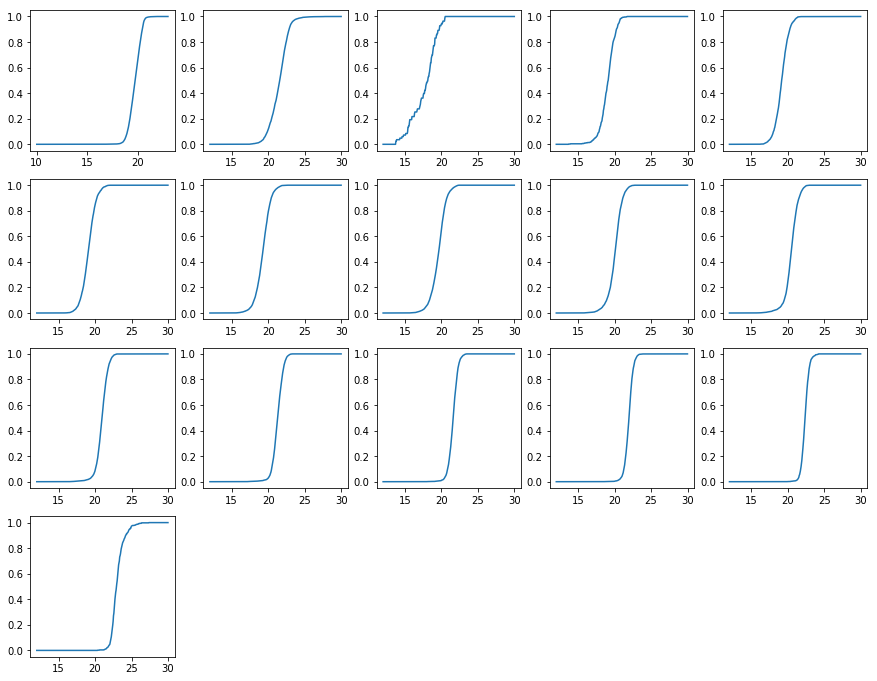

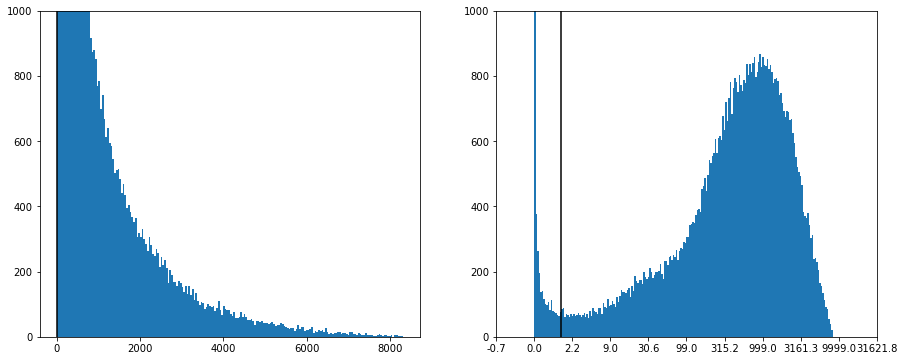

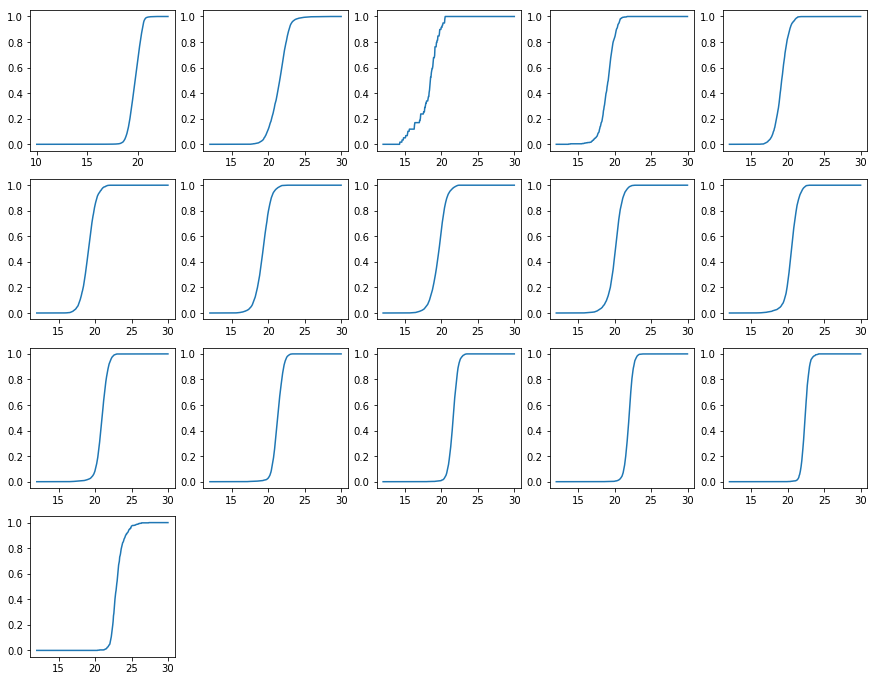

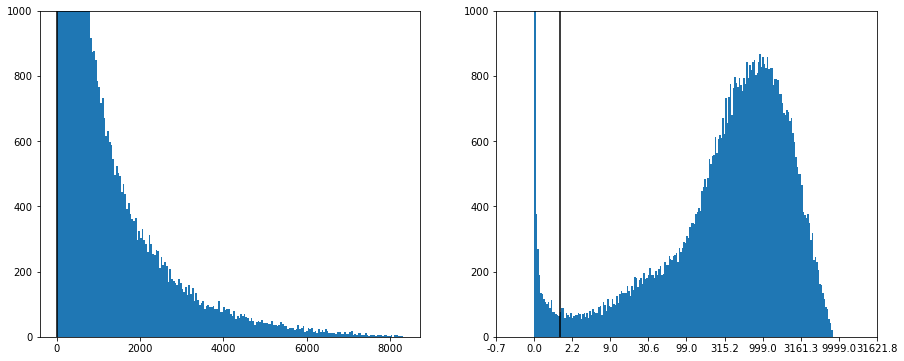

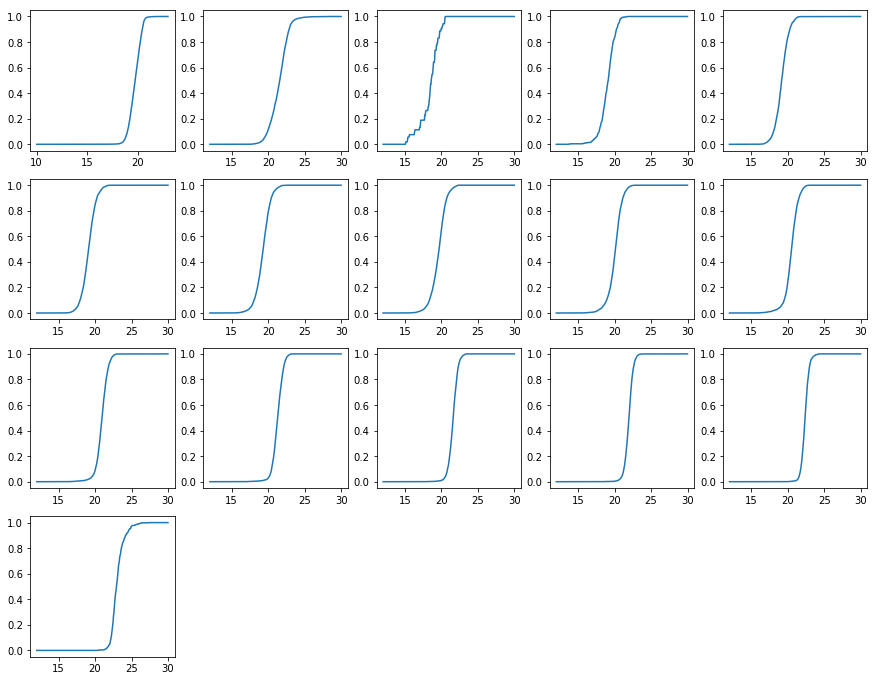

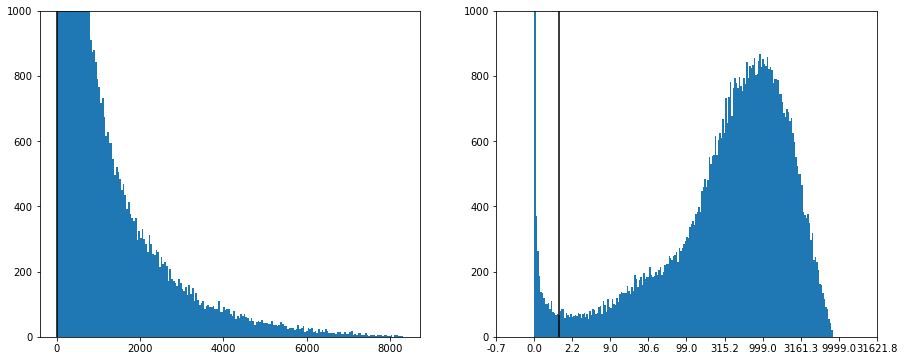

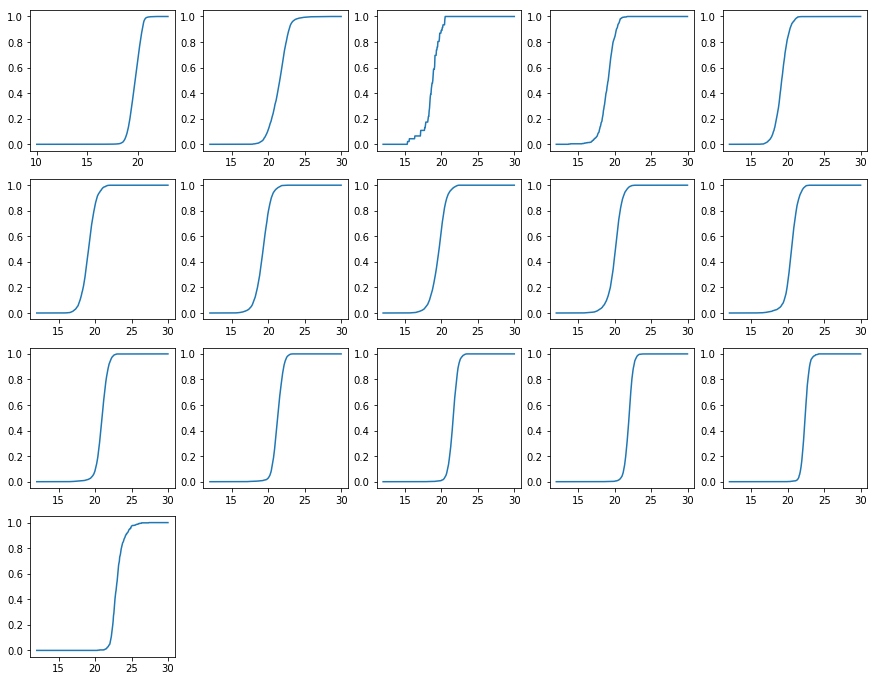

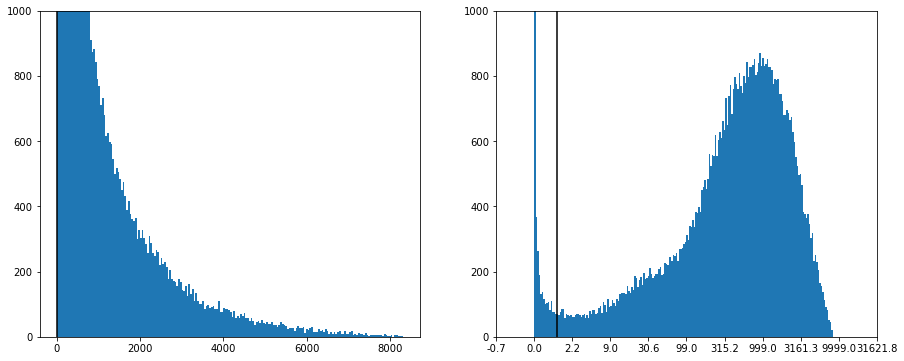

In [146]:
for j in range(10):
    iteration = j+3 
    print("Iteration {}".format(iteration))
    print("=============")
    ## Get new parameters
    # Number of matched sources per bin
    numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                            for c in range(len(numbers_combined_bins))])
    print("numbers_lofar_combined_bins")
    print(numbers_lofar_combined_bins)
    # q_0
    Q_0_colour_est = numbers_lofar_combined_bins/len(lofar) ### Q_0
    Q_0_colour = q0_min_level(Q_0_colour_est, min_level=0.001)
    print("Q_0_colour")
    print(Q_0_colour)
    q0_total = np.sum(Q_0_colour)
    print("Q_0_total: ", q0_total)
    # q_m
    q_m = []
    # W1 only sources
    q_m.append(get_q_m(lofar["W1mag"][lofar["category"] == 0], 
                   bin_list_w1, 
                   numbers_lofar_combined_bins[0], 
                   n_m[0], 
                   field.area, 
                   radius=radius))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m.append(get_q_m(lofar["i"][lofar["category"] == i], 
                       bin_list_i, 
                       numbers_lofar_combined_bins[i], 
                       n_m[i], 
                       field.area, 
                       radius=radius))
    # Save new parameters
    if save_intermediate:
        pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                    open("{}/lofar_params_{}.pckl".format(idp, iteration), 'wb'))
    if plot_intermediate:
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k)
        plt.savefig('{}/q0_{}.png'.format(idp, iteration))
        del fig
    ## Define new likelihood_ratio
    likelihood_ratio = MultiMLEstimatorU(Q_0_colour, n_m, q_m, centers)
    def ml(i):
        return apply_ml(i, likelihood_ratio)
    ## Run the ML
    res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)
    lofar["lr_index_{}".format(iteration)] = np.nan
    lofar["lr_dist_{}".format(iteration)] = np.nan
    lofar["lr_{}".format(iteration)] = np.nan
    (lofar["lr_index_{}".format(iteration)][idx_lofar_unique], 
     lofar["lr_dist_{}".format(iteration)][idx_lofar_unique], 
     lofar["lr_{}".format(iteration)][idx_lofar_unique]) = list(map(list, zip(*res)))
    lofar["lr_{}".format(iteration)][np.isnan(lofar["lr_{}".format(iteration)])] = 0
    ## Get and apply the threshold
    threshold = np.percentile(lofar["lr_{}".format(iteration)], 100*(1 - q0_total))
    #threshold = get_threshold(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)])
    print("Threshold: ", threshold)
    if plot_intermediate:
        fig = plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.hist(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)], bins=200)
        plt.vlines([threshold], 0, 1000)
        plt.ylim([0,1000])
        plt.subplot(1,2,2)
        plt.hist(np.log10(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)]+1), bins=200)
        plt.vlines(np.log10(threshold+1), 0, 1000)
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
        plt.ylim([0,1000])
        plt.savefig('{}/lr_distribution_{}.png'.format(idp, iteration))
        del fig
    ## Apply the threshold
    lofar["lr_index_sel_{}".format(iteration)] = lofar["lr_index_{}".format(iteration)]
    lofar["lr_index_sel_{}".format(iteration)][lofar["lr_{}".format(iteration)] < threshold] = np.nan
    ## Enter changes into the catalogue
    # Clear aux columns
    lofar["category"] = np.nan
    lofar["W1mag"] = np.nan
    lofar["i"] = np.nan
    # Update data
    c = ~np.isnan(lofar["lr_index_sel_{}".format(iteration)])
    indices = lofar["lr_index_sel_{}".format(iteration)][c].astype(int)
    lofar["category"][c] = combined[indices]["category"]
    lofar["W1mag"][c] = combined[indices]["W1mag"]
    lofar["i"][c] = combined[indices]["i"]
    # Save the data
    if save_intermediate:
        lofar.write("{}/lofar_m{}.fits".format(idp, iteration), format="fits")
    ## Compute number of changes
    n_changes = np.sum((
            lofar["lr_index_sel_{}".format(iteration)] != lofar["lr_index_sel_{}".format(iteration-1)]) & 
            ~np.isnan(lofar["lr_index_sel_{}".format(iteration)]) &
            ~np.isnan(lofar["lr_index_sel_{}".format(iteration-1)]))
    print("N changes: ", n_changes)
    t_changes = np.sum((
            lofar["lr_index_sel_{}".format(iteration)] != lofar["lr_index_sel_{}".format(iteration-1)]))
    print("T changes: ", t_changes)
    ## Check changes
    if n_changes == 0:
        break
    else:
        print("******** continue **********")

In [147]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])
numbers_lofar_combined_bins

array([19659,  3798,    39,   504,  2313,  3305,  4738,  5275,  5089,
        4589,  4387,  3865,  3320,  4413,  1681,   538])

In [148]:
good = True

In [150]:
from shutil import copyfile
if good:
    if os.path.exists("lofar_params.pckl"):
        os.remove("lofar_params.pckl")
    copyfile("{}/lofar_params_{}.pckl".format(idp, iteration), "lofar_params.pckl")